<a href="https://colab.research.google.com/github/merveekilci/SakaryaUniversity/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Introduction

The rapid advancements in Artificial Intelligence (AI) and Deep Learning (DL) have revolutionized healthcare, particularly in the domain of Computer Vision. Early diagnosis of skin diseases, especially melanoma, is critical for effective treatment and patient survival. However, diagnosing skin conditions accurately often requires expertise and time, which may not be readily available in remote or resource-limited settings.

This project leverages deep learning to classify images of skin lesions into multiple categories, enabling an automated diagnostic tool that can assist dermatologists or serve as a preliminary screening method for patients. By using the HAM10000 dataset, this project focuses on building a deep learning model capable of accurate and reliable classification of skin lesion images.

Project Objectives

The primary goals of this project are as follows:

Develop a deep learning model for skin lesion classification that can categorize images into seven distinct classes. Ensure high accuracy while maintaining generalization across unseen data to prevent overfitting. Analyze and visualize the results, including confusion matrices, accuracy graphs, and loss graphs, to identify strengths and limitations of the model. Provide insights into how deep learning models can be used in healthcare for early disease diagnosis.

Dataset Overview

The HAM10000 ("Human Against Machine with 10000 Training Images") dataset is a collection of 10,015 dermatoscopic images categorized into seven skin lesion classes:

nv (Melanocytic nevi): Common moles. mel (Melanoma): A dangerous form of skin cancer. bkl (Benign keratosis-like lesions). bcc (Basal cell carcinoma). akiec (Actinic keratoses and intraepithelial carcinoma): Precancerous lesions. vasc (Vascular lesions): Blood vessel-related lesions. df (Dermatofibroma): Rare benign skin lesions.

This research aims to develop a deep learning-based application to assist in the detection of skin diseases. The classification system leverages state-of-the-art, pre-trained neural networks such as MobileNet, AlexNet, known for their success in object recognition and similar tasks. The proposed system allows patients to monitor their skin lesions using their mobile devices. By capturing images with the device's camera, users can quickly and easily determine the condition of their lesions. If necessary, they will be directed to seek professional assistance for medication or other interventions, such as isolation in the case of contagious diseases.

Unique Contribution of the Project: The innovative value of this project lies in developing a mobile-accessible, deep learning-based classification system for early detection of skin diseases. By automating the extraction of complex features using deep learning models, this system accelerates the detection and classification process. This ensures timely professional intervention for users, significantly enhancing the healthcare delivery system. The project emphasizes making advanced diagnostic tools accessible to the general public through mobile devices.

In [ ]:
from numpy.random import seed
seed(101)  # Set random seed for NumPy
import tensorflow as tf
tf.random.set_seed(101)  # Set random seed for TensorFlow

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil

# TensorFlow/Keras modules

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from google.colab import drive  # To mount Google Drive in Colab

# For inline plotting in Jupyter Notebooks
%matplotlib inline


In [ ]:

drive.mount('/content/drive') # Mount Google Drive to access data



Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/My Drive/input') # Define the directory containing the dataset


['HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2']

In [ ]:
# Create a directory
base_dir = 'base_dir'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)
else:
    print(f"{base_dir} zaten mevcut.")

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir

train_dir = os.path.join(base_dir, 'train_dir')
os.makedirs(train_dir, exist_ok=True)

# 'val_dir'
val_dir = os.path.join(base_dir, 'val_dir')
os.makedirs(val_dir, exist_ok=True)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class


classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# 'train_dir' folder strcuture
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)



# Define as a list
classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# 'val_dir' folder structure
for class_name in classes:
    class_dir = os.path.join(val_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

In [ ]:
df_data = pd.read_csv('/content/drive/My Drive/input/HAM10000_metadata.csv') #import metada.csv

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [ ]:
# This code identifies duplicate images in the 'lesion_id' column
# and determines which lesions have only one image.

def identify_duplicates(x):
    # Create a list of unique values from the 'lesion_id' column
    unique_list = list(df['lesion_id'])

    # If 'x' is in the list of unique lesion IDs, mark it as 'no_duplicates'
    # Otherwise, mark it as 'has_duplicates'
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# Copy the 'lesion_id' column to a new column named 'duplicates'
df_data['duplicates'] = df_data['lesion_id']

# Apply the duplicate identification function to the 'duplicates' column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

# Display the first few rows of the dataframe to verify the results
df_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [ ]:
df_data['duplicates'].value_counts()

,count
duplicates,
no_duplicates,5514
has_duplicates,4501


In [ ]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [ ]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [ ]:
df_val['dx'].value_counts()

,count
dx,
nv,751
bkl,75
mel,39
bcc,30
akiec,26
vasc,11
df,6


In [ ]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [ ]:
df_train['dx'].value_counts()

,count
dx,
nv,5954
mel,1074
bkl,1024
bcc,484
akiec,301
vasc,131
df,109


In [ ]:
df_val['dx'].value_counts()

,count
dx,
nv,751
bkl,75
mel,39
bcc,30
akiec,26
vasc,11
df,6


In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/content/drive/My Drive/input/HAM10000_images_part_1')
folder_2 = os.listdir('/content/drive/My Drive/input/HAM10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/My Drive/input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/My Drive/input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
# Transfer the val images

for image in val_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/My Drive/input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/My Drive/input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [ ]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [ ]:
# Note: We are not augmenting images for class 'nv' (which is often overrepresented).
class_list = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']  # List of classes to augment

for item in class_list:

    # Create temporary directories to store images for augmentation.
    # These directories will be deleted after augmentation.
    aug_dir = 'aug_dir'  # Base directory for augmentation
    os.mkdir(aug_dir)

    # Create a subdirectory to store images of the current class being augmented.
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Select the current class to augment.
    img_class = item

    # List all images in the training directory for the selected class.
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images of the current class to the temporary augmentation directory.
    for fname in img_list:
        src = os.path.join('base_dir/train_dir/' + img_class, fname)  # Source path
        dst = os.path.join(img_dir, fname)  # Destination path
        shutil.copyfile(src, dst)  # Copy image to the augmentation directory

    # Define paths for the augmentation process.
    # 'path' points to the directory containing images to be augmented.
    # 'save_path' is the target directory where augmented images will be saved.
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create an ImageDataGenerator to apply transformations and augment the images.
    datagen = ImageDataGenerator(
        rotation_range=180,         # Rotate images by up to 180 degrees
        width_shift_range=0.1,      # Randomly shift images horizontally by up to 10%
        height_shift_range=0.1,     # Randomly shift images vertically by up to 10%
        zoom_range=0.1,             # Zoom in or out by up to 10%
        horizontal_flip=True,       # Flip images horizontally
        vertical_flip=True,         # Flip images vertically
        fill_mode='nearest'         # Fill in empty pixels using the nearest mode
    )

    batch_size = 50  # Number of images processed at a time during augmentation

    # Configure the data generator to save augmented images directly to the class folder.
    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Define the target number of images we want in each class after augmentation.
    num_aug_images_wanted = 6000

    # Count the number of images currently available in the class folder.
    num_files = len(os.listdir(img_dir))

    # Calculate the number of augmentation batches required to reach the target.
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # Run the data generator to create the augmented images.
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # After augmentation, delete the temporary directory containing the raw images.
    shutil.rmtree('aug_dir')


Found 5920 images belonging to 1 classes.
Found 5920 images belonging to 1 classes.
Found 5858 images belonging to 1 classes.
Found 5217 images belonging to 1 classes.
Found 5290 images belonging to 1 classes.
Found 4410 images belonging to 1 classes.


In [ ]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
6020
6020
6008
6017
6040
6010


In [ ]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


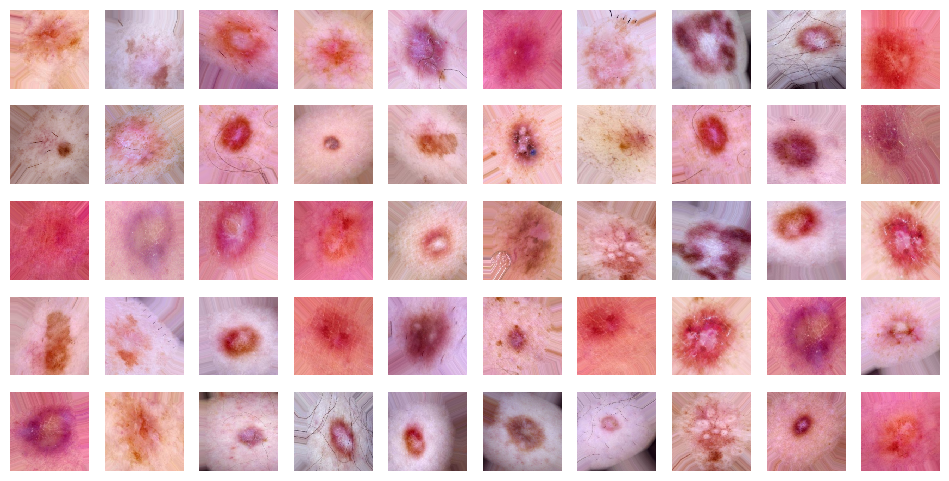

In [ ]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None):  # Default figure size is (12, 6)
    # If the input images are numpy arrays, ensure proper formatting for display
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)  # Convert images to 8-bit unsigned integers
        # If images don't have 3 color channels, transpose the dimensions to match (batch, height, width, channels)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))  # Rearrange dimensions for visualization

    # Create a new figure with the specified size
    f = plt.figure(figsize=figsize)

    # Determine the number of columns based on the total number of images and the specified rows
    # If the total images are not evenly divisible by the row count, add an extra column
    cols = len(ims) // rows if len(ims) % rows == 0 else len(ims) // rows + 1

    # Loop through and plot each image
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i + 1)  # Add a subplot for each image
        sp.axis('Off')  # Turn off the axis for cleaner visualization

        # If titles are provided, display them above the corresponding images
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)

        # Display the image, with optional interpolation
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# Call the function to display images. Pass image data to 'imgs'. Titles (labels) can be added if needed.
plots(imgs, titles=None)  # Use titles=labels to display image labels


In [ ]:
# Define the paths to the training and validation directories
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

# Calculate the number of training and validation samples from the dataframes
num_train_samples = len(df_train)  # Total number of images in the training set
num_val_samples = len(df_val)      # Total number of images in the validation set

# Set the batch size for training and validation
train_batch_size = 10  # Number of images processed in each training batch
val_batch_size = 10    # Number of images processed in each validation batch

# Define the target image size (input size for the model)
image_size = 224  # Standard size for models like ResNet, VGG, etc.

# Calculate the number of steps per epoch for training and validation
# np.ceil ensures the number of steps rounds up to process all images, even if the last batch is smaller
train_steps = np.ceil(num_train_samples / train_batch_size)  # Total training steps per epoch
val_steps = np.ceil(num_val_samples / val_batch_size)        # Total validation steps per epoch


In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=train_batch_size,
    class_mode='categorical'  # One-hot encoding for labels
)

valid_batches = datagen.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    class_mode='categorical'  # One-hot encoding for labels
)


# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 42069 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [ ]:
# create a copy of a mobilenet model

mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
type(mobile.layers)

list

In [ ]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [ ]:
from tensorflow.keras.layers import Flatten

# Create a new dense layer for predictions
# The number 7 represents the number of classes in the classification task
x = mobile.layers[-6].output  # Extract output from the 6th-to-last layer of the pre-trained MobileNet model
x = Flatten()(x)  # Flatten the output to convert it into a 1D vector for the Dense layer
x = Dropout(0.25)(x)  # Apply dropout to reduce overfitting (25% of nodes are randomly dropped during training)
predictions = Dense(7, activation='softmax')(x)  # Final Dense layer with 7 output nodes (one for each class)

# Define the model by specifying inputs and outputs
model = Model(inputs=mobile.input, outputs=predictions)  # The model takes MobileNet inputs and outputs class predictions


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,580,103 (13.66 MB)

 Trainable params: 3,558,215 (13.57 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
# Import necessary metrics from Keras
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

# Define a custom metric for Top-3 Accuracy
# This function calculates how often the true label is among the top 3 predicted classes
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)  # k=3 specifies the top 3 predictions to check

# Define a custom metric for Top-2 Accuracy
# This function calculates how often the true label is among the top 2 predicted classes
def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)  # k=2 specifies the top 2 predictions to check


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy]
)

In [ ]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:
# Define the file path to save the best model
filepath = "model.keras"

# Create a ModelCheckpoint to save the model with the highest validation Top-3 Accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')
# - filepath: Path where the model will be saved
# - monitor: Monitors 'val_top_3_accuracy' (validation Top-3 accuracy)
# - verbose=1: Displays messages when the model is saved
# - save_best_only=True: Saves the model only when its performance improves
# - mode='max': Higher values of 'val_top_3_accuracy' are considered better

# Create a ReduceLROnPlateau callback to reduce the learning rate if the model's performance plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)
# - monitor: Tracks 'val_top_3_accuracy' to adjust the learning rate
# - factor=0.5: Reduces the learning rate by half when triggered
# - patience=2: Waits for 2 epochs without improvement before reducing the learning rate
# - verbose=1: Displays messages when the learning rate is reduced
# - mode='max': Higher 'val_top_3_accuracy' values are better
# - min_lr=0.00001: Sets the minimum learning rate to prevent it from going too low

# Combine the callbacks into a list to pass to the model during training
callbacks_list = [checkpoint, reduce_lr]

# Train the model using the fit method
history = model.fit(train_batches,
                    steps_per_epoch=int(train_steps),  # Convert to integer to ensure proper calculation
                    class_weight=class_weights,  # Adjust class weights to handle class imbalance
                    validation_data=valid_batches,  # Use validation data during training
                    validation_steps=int(val_steps),  # Convert to integer for correct validation step calculation
                    epochs=30,  # Train the model for 30 epochs
                    verbose=1,  # Display detailed training progress
                    callbacks=callbacks_list)  # Use checkpoint and learning rate callbacks during training


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - categorical_accuracy: 0.2883 - loss: 24.9303 - top_2_accuracy: 0.4795 - top_3_accuracy: 0.6336
Epoch 1: val_top_3_accuracy improved from -inf to 0.05650, saving model to model.keras
908/908 ━━━━━━━━━━━━━━━━━━━━ 690s 751ms/step - categorical_accuracy: 0.2883 - loss: 24.9150 - top_2_accuracy: 0.4796 - top_3_accuracy: 0.6336 - val_categorical_accuracy: 0.0224 - val_loss: 86.7384 - val_top_2_accuracy: 0.0394 - val_top_3_accuracy: 0.0565 - learning_rate: 0.0100
Epoch 2/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - categorical_accuracy: 0.3903 - loss: 3.4606 - top_2_accuracy: 0.5797 - top_3_accuracy: 0.7305

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


908/908 ━━━━━━━━━━━━━━━━━━━━ 635s 700ms/step - categorical_accuracy: 0.3904 - loss: 3.4597 - top_2_accuracy: 0.5798 - top_3_accuracy: 0.7305 - learning_rate: 0.0100
Epoch 3/30


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_top_3_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_top_3_accuracy` which is not available. Available metrics are: categorical_accuracy,loss,top_2_accuracy,top_3_accuracy,learning_rate.
  callback.on_epoch_end(epoch, logs)


908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - categorical_accuracy: 0.5185 - loss: 1.5434 - top_2_accuracy: 0.7304 - top_3_accuracy: 0.8554
Epoch 3: val_top_3_accuracy improved from 0.05650 to 0.44350, saving model to model.keras
908/908 ━━━━━━━━━━━━━━━━━━━━ 657s 723ms/step - categorical_accuracy: 0.5185 - loss: 1.5433 - top_2_accuracy: 0.7304 - top_3_accuracy: 0.8554 - val_categorical_accuracy: 0.0938 - val_loss: 8.3306 - val_top_2_accuracy: 0.1493 - val_top_3_accuracy: 0.4435 - learning_rate: 0.0100
Epoch 4/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 598s 659ms/step - categorical_accuracy: 0.5939 - loss: 1.3088 - top_2_accuracy: 0.7908 - top_3_accuracy: 0.8925 - learning_rate: 0.0100
Epoch 5/30
575/908 ━━━━━━━━━━━━━━━━━━━━ 3:42 668ms/step - categorical_accuracy: 0.5995 - loss: 1.2851 - top_2_accuracy: 0.7901 - top_3_accuracy: 0.8908
Epoch 5: val_top_3_accuracy improved from 0.44350 to 0.87313, saving model to model.keras
908/908 ━━━━━━━━━━━━━━━━━━━━ 424s 467ms/step - categorical_accuracy: 0.6049 

In [ ]:
model.metrics_names

['loss', 'compile_metrics']

In [ ]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
    model.evaluate(test_batches,  # use evaluate for performance
                   steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)


938/938 ━━━━━━━━━━━━━━━━━━━━ 53s 56ms/step - categorical_accuracy: 0.7701 - loss: 0.7802 - top_2_accuracy: 0.8824 - top_3_accuracy: 0.9515
val_loss: 0.36444589495658875
val_cat_acc: 0.8891258239746094
val_top_2_acc: 0.9541577696800232
val_top_3_acc: 0.9850746393203735


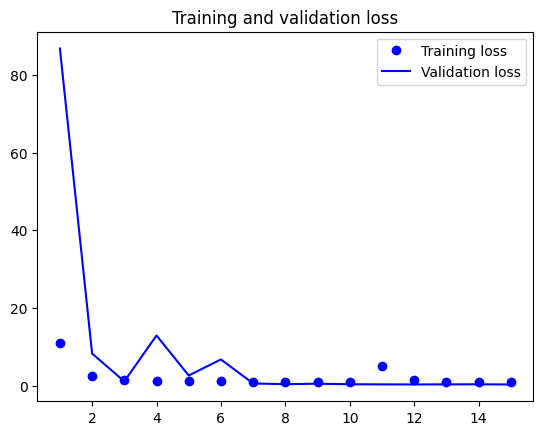

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation metrics from the history object
acc = history.history['categorical_accuracy']  # Training categorical accuracy
val_acc = history.history['val_categorical_accuracy']  # Validation categorical accuracy
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss
train_top2_acc = history.history['top_2_accuracy']  # Training Top-2 accuracy
val_top2_acc = history.history['val_top_2_accuracy']  # Validation Top-2 accuracy
train_top3_acc = history.history['top_3_accuracy']  # Training Top-3 accuracy
val_top3_acc = history.history['val_top_3_accuracy']  # Validation Top-3 accuracy

# Adjust epochs length to match the shortest metric to avoid plotting errors
min_length = min(len(loss), len(val_loss), len(acc), len(val_acc))

# Create an epochs range that matches the shortest metric length
epochs = range(1, min_length + 1)

# Plot training and validation loss
plt.plot(epochs, loss[:min_length], 'bo', label='Training loss')  # Training loss in blue dots
plt.plot(epochs, val_loss[:min_length], 'b', label='Validation loss')  # Validation loss in solid blue line
plt.title('Training and validation loss')  # Title of the plot
plt.legend()  # Display legend to differentiate between training and validation curves
plt.show()  # Display the plot


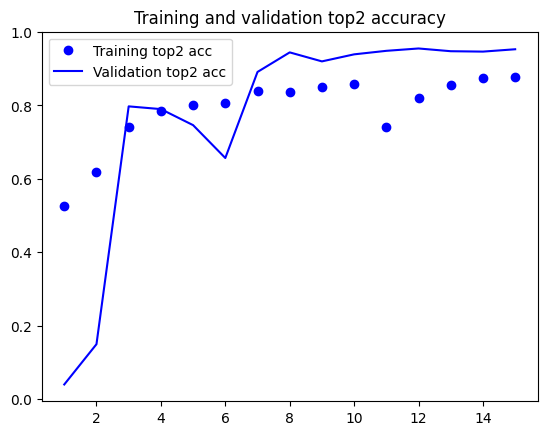

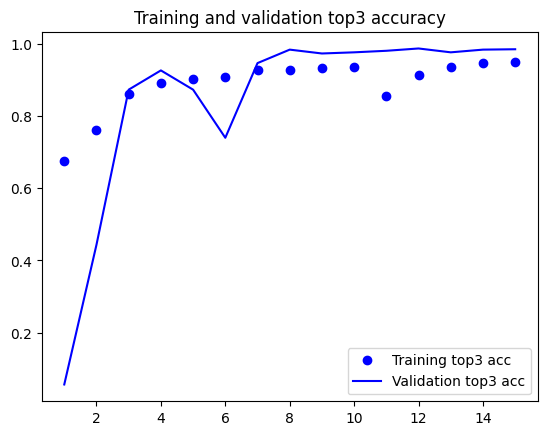

In [ ]:
# Find the minimum epoch length for Top-2 accuracy (between training and validation)
min_length_top2 = min(len(train_top2_acc), len(val_top2_acc))
# This ensures both training and validation Top-2 accuracy arrays are the same length to avoid plotting errors

# Find the minimum epoch length for Top-3 accuracy (between training and validation)
min_length_top3 = min(len(train_top3_acc), len(val_top3_acc))
# Similarly, this prevents mismatches in epoch lengths for Top-3 accuracy plotting

# Adjust the epochs for Top-2 accuracy based on the shortest array length
epochs_top2 = range(1, min_length_top2 + 1)

# Plot the Top-2 training and validation accuracy
plt.plot(epochs_top2, train_top2_acc[:min_length_top2], 'bo', label='Training top2 acc')  # Training in blue dots
plt.plot(epochs_top2, val_top2_acc[:min_length_top2], 'b', label='Validation top2 acc')  # Validation in solid blue line
plt.title('Training and validation top2 accuracy')  # Set the plot title
plt.legend()  # Display the legend to differentiate between training and validation
plt.figure()  # Create a new figure for the next plot

# Adjust the epochs for Top-3 accuracy based on the shortest array length
epochs_top3 = range(1, min_length_top3 + 1)

# Plot the Top-3 training and validation accuracy
plt.plot(epochs_top3, train_top3_acc[:min_length_top3], 'bo', label='Training top3 acc')  # Training in blue dots
plt.plot(epochs_top3, val_top3_acc[:min_length_top3], 'b', label='Validation top3 acc')  # Validation in solid blue line
plt.title('Training and validation top3 accuracy')  # Set the plot title
plt.legend()  # Display the legend to differentiate between training and validation
plt.show()  # Display both plots


In [ ]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [ ]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
# make a prediction
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)


938/938 ━━━━━━━━━━━━━━━━━━━━ 55s 57ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # If normalization is enabled, convert the confusion matrix values to percentages
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true class total)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Print the confusion matrix to the console (useful for debugging or logging)
    print(cm)

    # Plot the confusion matrix as an image (heatmap)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Display the color scale (legend) for the heatmap

    # Set the labels for the x and y axes (class names)
    tick_marks = np.arange(len(classes))  # Create tick marks for each class
    plt.xticks(tick_marks, classes, rotation=45)  # Label x-axis with class names
    plt.yticks(tick_marks, classes)  # Label y-axis with class names

    # Format the numbers inside the confusion matrix
    fmt = '.2f' if normalize else 'd'  # Use decimal (2f) for normalized, integer (d) otherwise
    thresh = cm.max() / 2.  # Set threshold to change text color for better visibility

    # Loop over each cell in the confusion matrix and add text annotations
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),  # Place text at the center of each cell
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # White text for dark cells, black for light cells

    # Label the axes
    plt.ylabel('True label')  # Y-axis label represents the actual class
    plt.xlabel('Predicted label')  # X-axis label represents the predicted class
    plt.tight_layout()  # Adjust layout to prevent label overlap


In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))


In [ ]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 13   3   7   0   1   2   0]
 [  0  27   1   0   1   1   0]
 [  0   1  32   0  18  24   0]
 [  0   0   0   3   0   3   0]
 [  0   0   4   0  25  10   0]
 [  0   3   3   0  20 724   1]
 [  0   0   0   0   0   1  10]]


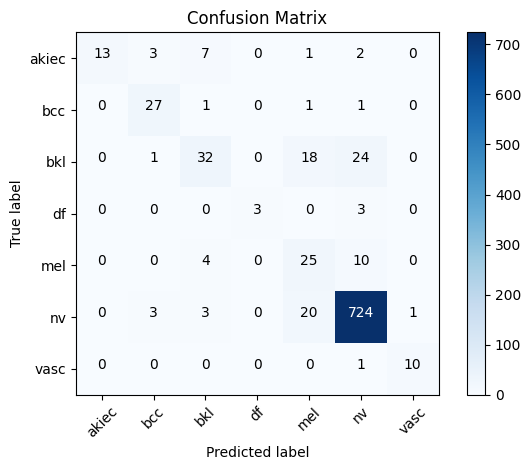

In [ ]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       1.00      0.50      0.67        26
         bcc       0.79      0.90      0.84        30
         bkl       0.68      0.43      0.52        75
          df       1.00      0.50      0.67         6
         mel       0.38      0.64      0.48        39
          nv       0.95      0.96      0.96       751
        vasc       0.91      0.91      0.91        11

    accuracy                           0.89       938
   macro avg       0.82      0.69      0.72       938
weighted avg       0.90      0.89      0.89       938

